In [2]:
#%pip install shap lime
#%pip install xgboost
#%pip install pytorch-tabnet

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from pytorch_tabnet.tab_model import TabNetClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular
import torch

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load the training data
try:
    df_train = pd.read_csv('/content/aps_failure_training_set.csv', na_values='na')
except FileNotFoundError:
    print("Training data file not found. Please make sure 'aps_failure_training_set.csv' is in the correct directory.")
    exit()

print("Initial Training Data Shape:", df_train.shape)
print("Initial Training Data Info:")
df_train.info()
print("Initial Training Data Description:")
print(df_train.describe())

Initial Training Data Shape: (60000, 171)
Initial Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 78.3+ MB
Initial Training Data Description:
             aa_000        ab_000        ac_000        ad_000        ae_000  \
count  6.000000e+04  13671.000000  5.666500e+04  4.513900e+04  57500.000000   
mean   5.933650e+04      0.713189  3.560143e+08  1.906206e+05      6.819130   
std    1.454301e+05      3.478962  7.948749e+08  4.040441e+07    161.543373   
min    0.000000e+00      0.000000  0.000000e+00  0.000000e+00      0.000000   
25%    8.340000e+02      0.000000  1.600000e+01  2.400000e+01      0.000000   
50%    3.077600e+04      0.000000  1.520000e+02  1.260000e+02      0.000000   
75%    4.866800e+04      0.000000  9.640000e+02  4.300000e+02      0.000000   
max    2.746564e+06    204.000000  2.130707e+09  8.584298e+09  21050.000000   

    

In [5]:
# --- Data Cleaning and Preparation ---

# Separate Target Variable
y = df_train['class']
X = df_train.drop('class', axis=1)

# Encode Target Variable
y = y.replace({'neg': 0, 'pos': 1})

# Missing Value Imputation (using mean)
for col in X.columns:
    if X[col].isnull().any():
        X[col].fillna(X[col].mean(), inplace=True)

print("\nMissing values after imputation:")
print(X.isnull().sum().sum()) # Should be 0


Missing values after imputation:
0


In [6]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nData shape after cleaning and scaling:")
print(X_scaled.shape)


Data shape after cleaning and scaling:
(60000, 170)


In [7]:
# --- Dimensionality Reduction (PCA) ---
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)

print("\nShape after PCA:", X_pca.shape)


Shape after PCA: (60000, 100)


In [8]:
# --- Model Training and Evaluation ---

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Create pipelines
pipeline_xgb = Pipeline([
    ('classifier', xgb.XGBClassifier(random_state=42, max_iter=1000, class_weight='balanced'))
])

pipeline_rf = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

pipeline_tabnet = Pipeline([
    ('classifier', TabNetClassifier(seed=42, verbose=0))
])


--- XGBoost ---

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11800
           1       0.82      0.72      0.77       200

    accuracy                           0.99     12000
   macro avg       0.91      0.86      0.88     12000
weighted avg       0.99      0.99      0.99     12000

Cost: $28,320
ROC AUC: 0.9888


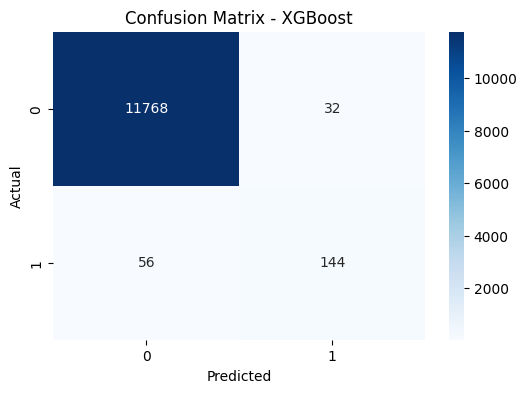


--- Random Forest ---

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11800
           1       0.92      0.36      0.52       200

    accuracy                           0.99     12000
   macro avg       0.96      0.68      0.76     12000
weighted avg       0.99      0.99      0.99     12000

Cost: $64,060
ROC AUC: 0.9917


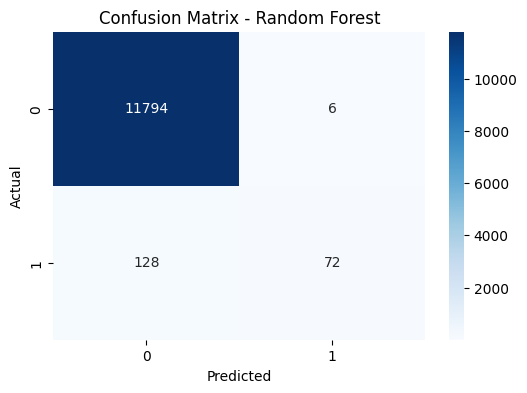


--- TabNet ---

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11800
           1       0.60      0.30      0.40       200

    accuracy                           0.98     12000
   macro avg       0.79      0.65      0.70     12000
weighted avg       0.98      0.98      0.98     12000

Cost: $69,910
ROC AUC: 0.9796


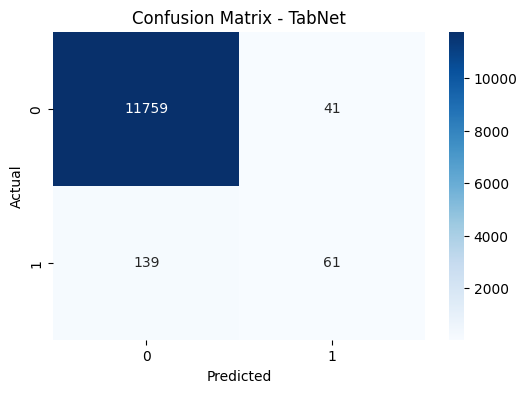

In [9]:
# Train and evaluate models
pipelines = [pipeline_xgb, pipeline_rf, pipeline_tabnet]
model_names = ['XGBoost', 'Random Forest', 'TabNet']
f1_scores = []

for pipe, name in zip(pipelines, model_names):
    print(f"\n--- {name} ---\n")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))
    f1_scores.append(report['1']['f1-score']) # Get F1-score for the positive class '1'
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cost = 10 * fp + 500 * fn
    # Calculate ROC AUC
    y_pred_proba = pipe.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Cost: ${cost:,}")
    print(f"ROC AUC: {roc_auc:.4f}")


    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    #plt.savefig(f'{name.replace(" ", "_")}_confusion_matrix.png')
    plt.close() # Close the plot to avoid displaying it in the console

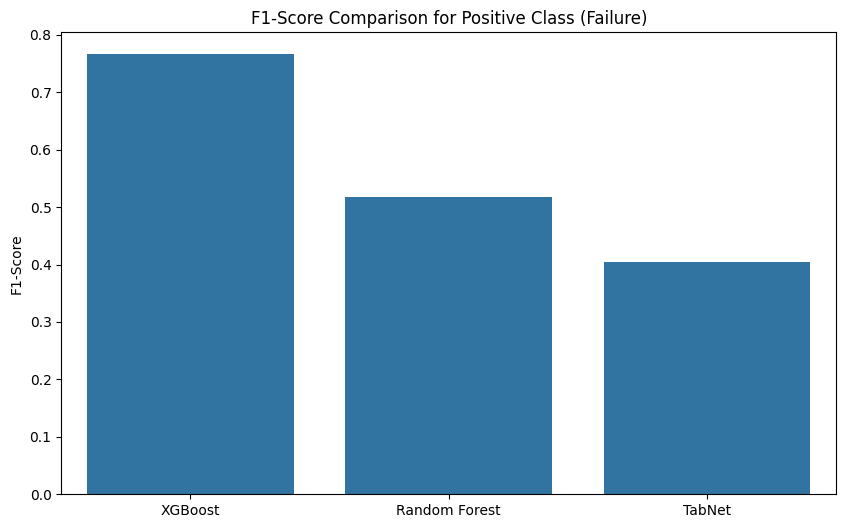

In [10]:
# --- Model Comparison ---
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=f1_scores)
plt.title('F1-Score Comparison for Positive Class (Failure)')
plt.ylabel('F1-Score')
plt.show()
#plt.savefig('f1_score_comparison.png')
plt.close()

#print("\nF1-Score comparison plot saved as 'f1_score_comparison.png'")

In [12]:
# Define model names in the same order as your pipelines
model_names = ['XGBoost', 'Random Forest', 'TabNet']

# Initialize trackers
best_f1 = 0
best_model_index = -1

# Loop over pipelines and evaluate F1-score for class 1
for i, pipeline in enumerate(pipelines):
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    class1_f1 = report['1']['f1-score']

    print(f"{model_names[i]} - Class 1 F1-score: {class1_f1:.4f}")

    if class1_f1 > best_f1:
        best_f1 = class1_f1
        best_model_index = i

# Select best model pipeline and classifier
best_model_pipeline = pipelines[best_model_index]
best_model = best_model_pipeline.named_steps['classifier']

print(f"\nBest Model Based on Class 1 F1-score: {model_names[best_model_index]}")

XGBoost - Class 1 F1-score: 0.7660
Random Forest - Class 1 F1-score: 0.5180
TabNet - Class 1 F1-score: 0.4040

Best Model Based on Class 1 F1-score: XGBoost


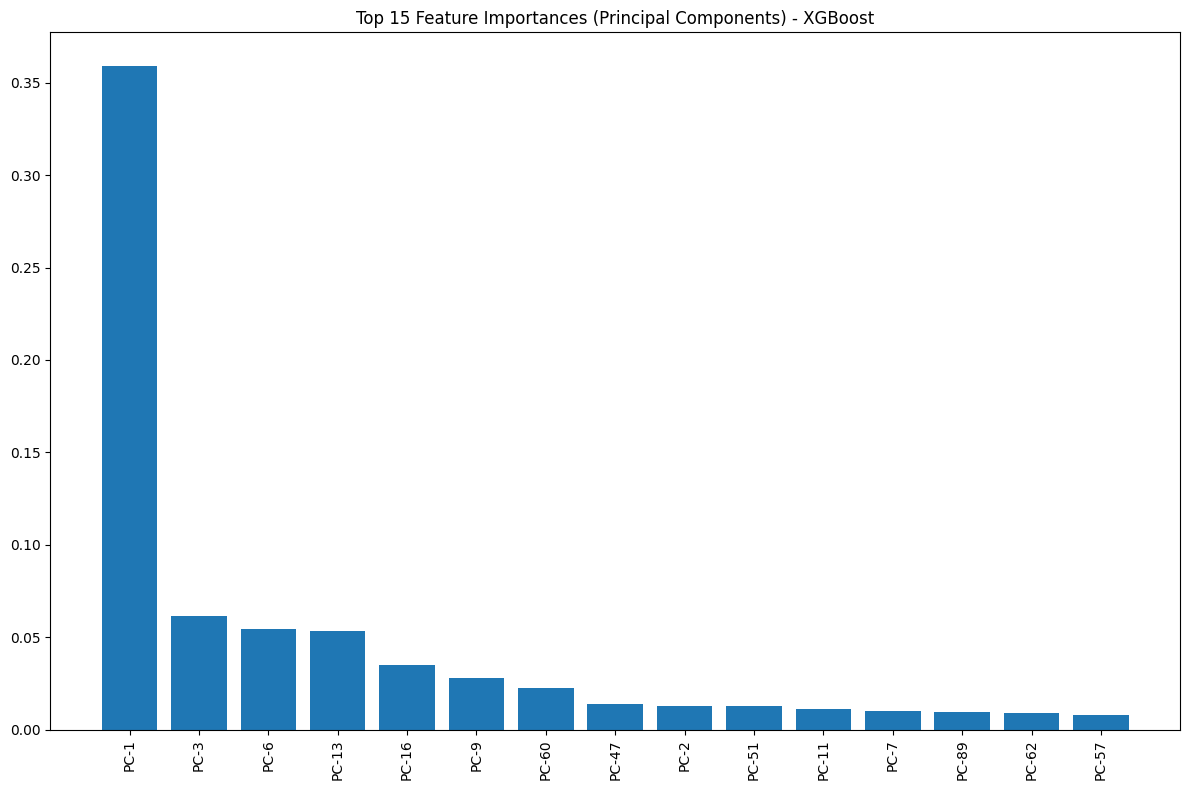

In [14]:
# Get feature importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
num_features_to_plot = 15

plt.figure(figsize=(12, 8))
plt.title(f"Top {num_features_to_plot} Feature Importances (Principal Components) - XGBoost")
plt.bar(range(num_features_to_plot), importances[indices][:num_features_to_plot], align='center')
plt.xticks(
    range(num_features_to_plot),
    [f'PC-{i+1}' for i in indices[:num_features_to_plot]],
    rotation=90
)
plt.tight_layout()
plt.show()
#plt.savefig('random_forest_feature_importance.png')
plt.close()

#print("Feature importance plot for Random Forest saved as 'random_forest_feature_importance.png'")


--- SHAP Interpretation ---


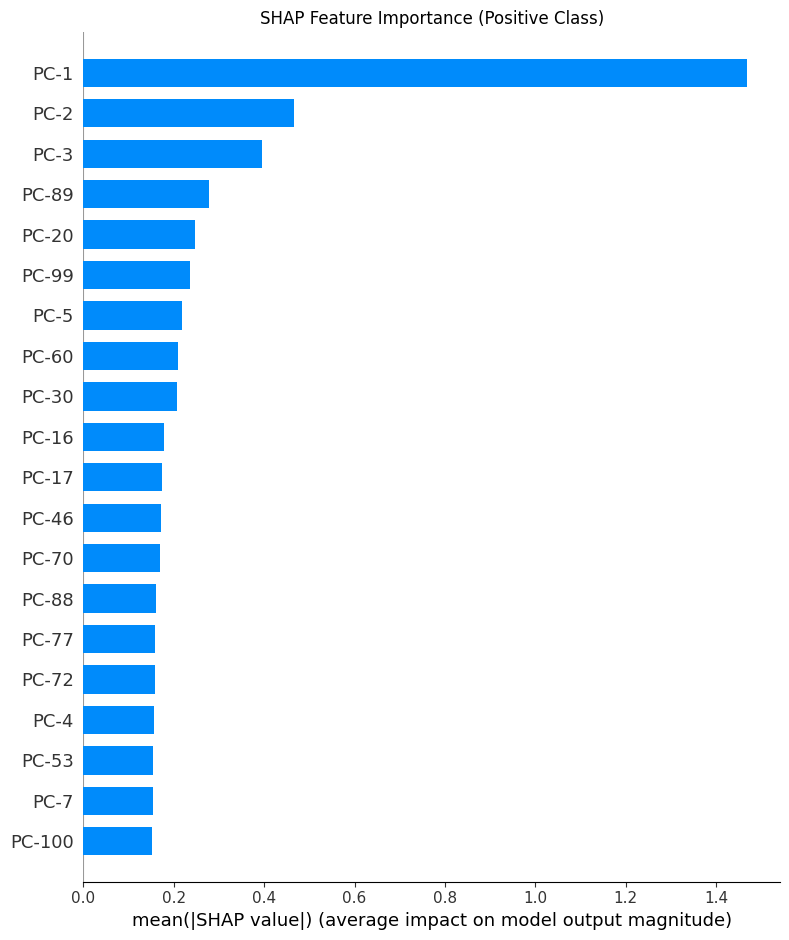

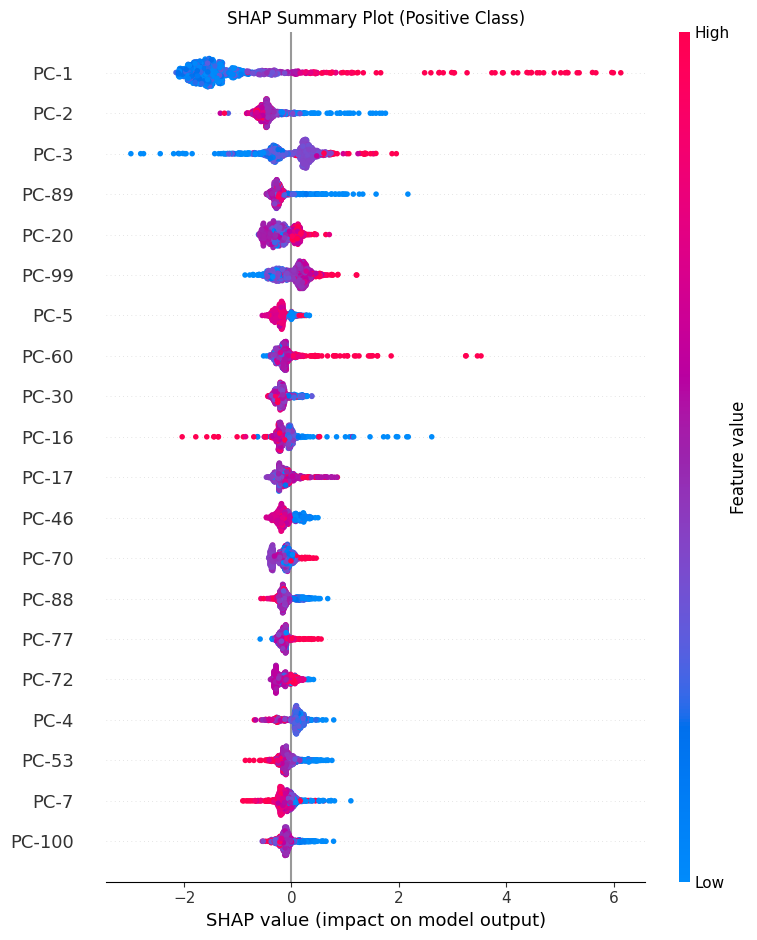

In [15]:
# --- SHAP Interpretation (Random Forest) ---
print("\n--- SHAP Interpretation ---")
# Use a subset of X_test for SHAP to speed up computation
X_test_display = pd.DataFrame(X_test, columns=[f'PC-{i+1}' for i in range(X_test.shape[1])])
X_test_subset = X_test_display.sample(n=min(1000, len(X_test_display)), random_state=42) # Sample up to 1000 instances for SHAP

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_subset)

# SHAP Summary Plot (Global Interpretability)
shap.summary_plot(shap_values, X_test_subset, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Positive Class)')
plt.tight_layout()
plt.show()
#plt.savefig('shap_summary_plot_positive_class.png')
plt.close()
#print("SHAP summary plot for positive class saved as 'shap_summary_plot_positive_class.png'")

shap.summary_plot(shap_values, X_test_subset, show=False)
plt.title('SHAP Summary Plot (Positive Class)')
plt.tight_layout()
plt.show()
#plt.savefig('shap_summary_plot_beeswarm_positive_class.png')
plt.close()
#print("SHAP beeswarm plot for positive class saved as 'shap_summary_plot_beeswarm_positive_class.png'")

In [16]:
# SHAP Force Plot (Individual Interpretability)
# Find an example of a positive prediction
pos_idx = np.where(y_test == 1)[0]
if len(pos_idx) > 0:
    sample_pos_idx = pos_idx[0] # Take the first positive example
    print(f"Generating SHAP force plot for a positive prediction (index {sample_pos_idx})...")
    # Ensure the index is correctly mapped from X_test to X_test_subset
    original_index_of_sample = X_test_display.index[sample_pos_idx]
    if original_index_of_sample in X_test_subset.index:
        shap_index = X_test_subset.index.get_loc(original_index_of_sample)
        shap.force_plot(explainer.expected_value[1], shap_values[1][shap_index], X_test_subset.loc[original_index_of_sample], matplotlib=True, show=False)
        plt.tight_layout()
        plt.show()
        #plt.savefig('shap_force_plot_positive_example.png')
        plt.close()
        print("SHAP force plot for a positive example saved as 'shap_force_plot_positive_example.png'")
    else:
        print(f"Sample at original index {sample_pos_idx} not in SHAP subset. Skipping force plot for positive example.")
else:
    print("No positive examples found in the test set for SHAP force plot.")

Generating SHAP force plot for a positive prediction (index 7)...
Sample at original index 7 not in SHAP subset. Skipping force plot for positive example.


In [17]:
# Find an example of a negative prediction
neg_idx = np.where(y_test == 0)[0]
if len(neg_idx) > 0:
    sample_neg_idx = neg_idx[0] # Take the first negative example
    print(f"Generating SHAP force plot for a negative prediction (index {sample_neg_idx})...")
    # Ensure the index is correctly mapped from X_test to X_test_subset
    original_index_of_sample = X_test_display.index[sample_neg_idx]
    if original_index_of_sample in X_test_subset.index:
        shap_index = X_test_subset.index.get_loc(original_index_of_sample)
        shap.force_plot(explainer.expected_value[1], shap_values[1][shap_index], X_test_subset.loc[original_index_of_sample], matplotlib=True, show=False)
        plt.tight_layout()
        plt.show()
        #plt.savefig('shap_force_plot_negative_example.png')
        plt.close()
        print("SHAP force plot for a negative example saved as 'shap_force_plot_negative_example.png'")
    else:
        print(f"Sample at original index {sample_neg_idx} not in SHAP subset. Skipping force plot for negative example.")
else:
    print("No negative examples found in the test set for SHAP force plot.")

Generating SHAP force plot for a negative prediction (index 0)...
Sample at original index 0 not in SHAP subset. Skipping force plot for negative example.


In [18]:
# --- LIME Interpretation (Random Forest) ---
print("\n--- LIME Interpretation ---")

# Define a prediction function for LIME
def predict_proba_rf(X):
    return best_model.predict_proba(X)

# Create a LimeTabularExplainer
feature_names = [f'PC-{i+1}' for i in range(X_pca.shape[1])]
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=['neg', 'pos'],
    mode='classification'
)

# Explain a positive prediction
if len(pos_idx) > 0:
    sample_pos_data = X_test[sample_pos_idx]
    print(f"Generating LIME explanation for a positive prediction (index {sample_pos_idx})...")
    exp_pos = explainer_lime.explain_instance(
        data_row=sample_pos_data,
        predict_fn=predict_proba_rf,
        num_features=10
    )
    exp_pos.show_in_notebook(show_table=True)
    #exp_pos.save_in_file('lime_explanation_positive_example.html')
    print("LIME explanation for a positive example saved as 'lime_explanation_positive_example.html'")


--- LIME Interpretation ---
Generating LIME explanation for a positive prediction (index 7)...


LIME explanation for a positive example saved as 'lime_explanation_positive_example.html'


In [19]:
# Explain a negative prediction
if len(neg_idx) > 0:
    sample_neg_data = X_test[sample_neg_idx]
    print(f"Generating LIME explanation for a negative prediction (index {sample_neg_idx})...")
    exp_neg = explainer_lime.explain_instance(
        data_row=sample_neg_data,
        predict_fn=predict_proba_rf,
        num_features=10
    )
    exp_neg.show_in_notebook(show_table=True)
    #exp_neg.save_in_file('lime_explanation_negative_example.html')
    print("LIME explanation for a negative example saved as 'lime_explanation_negative_example.html'")

print("\nAnalysis complete. XGBoost model provides the best performance, and interpretability insights are generated.")

Generating LIME explanation for a negative prediction (index 0)...


LIME explanation for a negative example saved as 'lime_explanation_negative_example.html'

Analysis complete. XGBoost model provides the best performance, and interpretability insights are generated.
